In [1]:
from spin import SpinConfiguration, create_J_matrix
import torch
import numpy as np
import matplotlib.pyplot as plt

### Functions to go from network state to spins and vice-versa

In [2]:
def spin_to_state(spin):
    N = spin.values.shape[0]
    state = torch.zeros((2*(N**2)))
    state[:N**2][torch.where(spin.values.flatten()==1)] = 1
    state[N**2:][torch.where(spin.values.flatten()==-1)] = 1
    return state

def state_to_spin(state):
    N = int(np.sqrt(state.shape[0]/2))
    values = torch.zeros(N**2, dtype=torch.float32)
    values[torch.where(state[:N**2]==1)] = 1
    values[torch.where(state[N**2:]==1)] = -1
    spin = SpinConfiguration(N, values.reshape(N, N))
    return spin

def create_empty_state(N):
    return torch.zeros(2*(N**2), dtype=torch.float32,requires_grad=True)

def create_input_batch(N, batch_size):
    return torch.cat([create_empty_state(N).reshape(1,-1)] * batch_size, dim=0)   

### Simplest form of the model - no TB in this one

In [3]:
class IsingSimpleFlowModel(torch.nn.Module):
    def __init__(self, N, n_hidden=256):
        super().__init__()
        
        self.N = N
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2 * self.N**2, n_hidden),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(n_hidden, 2 * self.N**2))
        
    def forward(self, state):
        mask = torch.cat([state[:,:N**2] + state[:,N**2:]]*2, dim=-1)
        probs = self.net(state).exp() * (1 - mask)
        choice = torch.distributions.categorical.Categorical(probs=probs).sample()#, validate_args=False).sample()
        state[torch.arange(state.shape[0], dtype=torch.int64), choice] = 1
        return state

### Get the spin configurations and energies through a loop

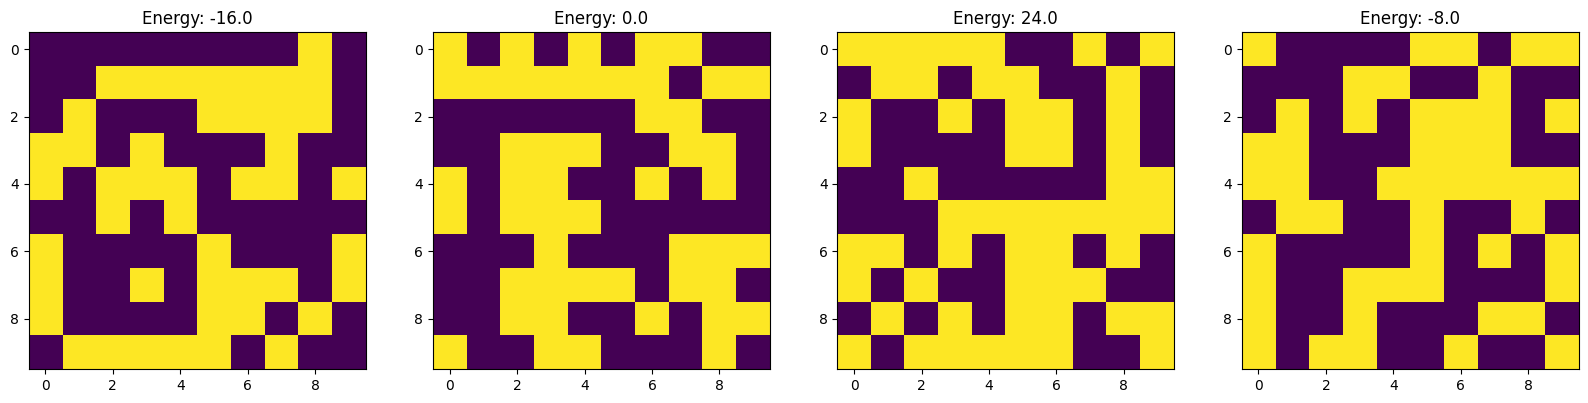

In [4]:
N=10
batch_size = 4
J = create_J_matrix(N, sigma=1) #Ferromagnetic (-1 for antiferro)

state = create_input_batch(N=N, batch_size=batch_size)
model = IsingSimpleFlowModel(N=N)

for _ in range(N**2):
    state = model(state)

spins = [state_to_spin(s) for s in state]
energies = [sp.get_energy(J) for sp in spins]

fig, ax = plt.subplots(figsize=(20, 6), ncols=batch_size)
for i, sp in enumerate(spins):
    ax[i].imshow(sp.values)
    ax[i].set_title(f"Energy: {energies[i]}")

### Get the energy through a torch module for gradient computation (batched)

In [49]:
class IsingEnergyModel(torch.nn.Module):
    def __init__(self, J):
        super().__init__()
        self.J = J
        self.flatten = torch.nn.Flatten()
        
    def _batched_states_to_spins(self, states):
        N = int(np.sqrt(states.shape[1]/2))
        spin_values = states[...,:N**2] + -1 * states[...,N**2:]
        return spin_values
        
    def forward(self, states):
        spin_values = self._batched_states_to_spins(states)
        energies = (-self.flatten(spin_values) @ self.J * self.flatten(spin_values)).sum(dim=-1)
        return energies

### Check that the energies are the same

In [50]:
energy_model = IsingEnergyModel(J)
energy_model(state)

tensor([-16.,   0.,  24.,  -8.], grad_fn=<SumBackward1>)